# Import libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTETomek
from sklearn.metrics import cohen_kappa_score

# File paths

In [9]:
TRAIN_PATH = "/kaggle/input/child-mind-institute-problematic-internet-use/train.csv"
TEST_PATH = "/kaggle/input/child-mind-institute-problematic-internet-use/test.csv"
SUBMISSION_PATH = "/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv"

# Data Wrangling and Feature Engineering 🔨

In [10]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

train = train.drop(columns=['id', 'Physical-Waist_Circumference'])  # Drop unnecessary columns
train = train.dropna(subset=['sii'])  # Remove rows with missing 'sii' values

# Split the cleaned training data into features (X) and target (y)
X_train = train.drop(columns=['sii'])
y_train = train['sii']

# Prepare test set
X_test = test.drop(columns=['id', 'Physical-Waist_Circumference'])  # Drop unnecessary columns

# Merge PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total in X_train
if 'PAQ_A-PAQ_A_Total' in X_train.columns and 'PAQ_C-PAQ_C_Total' in X_train.columns:
    X_train['PAQ_Total'] = X_train['PAQ_A-PAQ_A_Total'].fillna(0) + X_train['PAQ_C-PAQ_C_Total'].fillna(0)
    X_train = X_train.drop(columns=['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'])  # Drop the original columns

# Merge PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total in X_test
if 'PAQ_A-PAQ_A_Total' in X_test.columns and 'PAQ_C-PAQ_C_Total' in X_test.columns:
    X_test['PAQ_Total'] = X_test['PAQ_A-PAQ_A_Total'].fillna(0) + X_test['PAQ_C-PAQ_C_Total'].fillna(0)
    X_test = X_test.drop(columns=['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'])  # Drop the original columns


# Numerical Data Preprocessing ⚙

In [11]:
common_cols = X_train.columns.intersection(X_test.columns)
numeric_cols_not_list = X_train.select_dtypes(include=['int64', 'float64']).columns.intersection(X_test.columns)
numerical_imputer = SimpleImputer(strategy='median')

numeric_cols = [
    "Physical-Height",
    "Physical-Weight",
    "Basic_Demos-Age",
    "SDS-SDS_Total_Raw",
    "Physical-BMI",
    "SDS-SDS_Total_T",
    "Physical-Systolic_BP",
    "Physical-HeartRate",
    "CGAS-CGAS_Score",
    "PreInt_EduHx-computerinternet_hoursday",
    "Basic_Demos-Sex",
    "Physical-Diastolic_BP",
    'PAQ_Total'
]

for col in numeric_cols:
    if col not in numeric_cols_not_list:
        numeric_cols.remove(col)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_imputer, numeric_cols),
    ])
subset_x_train = X_train[numeric_cols]

X_train = preprocessor.fit_transform(subset_x_train)

X_train_preprocessed_df = pd.DataFrame(X_train, columns=numeric_cols)

numerical_imputer = SimpleImputer(strategy='mean')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_imputer, numeric_cols),
    ])

preprocessor.fit(X_train_preprocessed_df)

common_cols = X_train_preprocessed_df.columns.intersection(X_test.columns)
# Transform both training and test sets
X_train_preprocessed = preprocessor.transform(X_train_preprocessed_df)
X_test_preprocessed = preprocessor.transform(X_test[numeric_cols])



# Ensemble Modeling and Prediction 🚀

In [12]:
# Apply SMOTETomek to balance the dataset
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_preprocessed, y_train)

models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(),
}

# Define models for each class
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgb = LGBMClassifier(random_state=42)

# Train models on the training data
rf.fit(X_train_resampled, y_train_resampled)
xgb.fit(X_train_resampled, y_train_resampled)
lgb.fit(X_train_resampled, y_train_resampled)

# Custom prediction function
def class_specific_predict(X, models, best_models_per_class):
    # Get predictions for each class using the best model
    class_probabilities = np.zeros((X.shape[0], len(best_models_per_class)))

    for class_label in best_models_per_class.index:
        model_name = best_models_per_class[class_label]
        class_probabilities[:, int(class_label)] = models[model_name].predict_proba(X)[:, int(class_label)]

    # Return the class with the highest probability
    return np.argmax(class_probabilities, axis=1)

# Define the models dictionary
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'LightGBM': lgb
}

# Define the best models for each class
best_models_per_class = pd.Series({
    0: 'Random Forest',
    1: 'Random Forest',
    2: 'Random Forest',
    3: 'LightGBM'
})

# Make predictions using the class-specific prediction function
y_test_pred = class_specific_predict(X_test_preprocessed, models, best_models_per_class)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test['id'],  # Correct IDs from the test data
    'sii': y_test_pred
})

# Ensure sii values are integers
submission_df['sii'] = submission_df['sii'].astype(int)

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print("Saved to submission.csv")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 6224, number of used features: 13
[LightGBM] [Info] Start training from score -1.405763
[LightGBM] [Info] Start training from score -1.400534
[LightGBM] [Info] Start training from score -1.377337
[LightGBM] [Info] Start training from score -1.362166
Saved to submission.csv


# Model Evaluation and Selection 🏆

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3313
[LightGBM] [Info] Number of data points in the train set: 4979, number of used features: 13
[LightGBM] [Info] Start training from score -1.407198
[LightGBM] [Info] Start training from score -1.417091
[LightGBM] [Info] Start training from score -1.368577
[LightGBM] [Info] Start training from score -1.353692


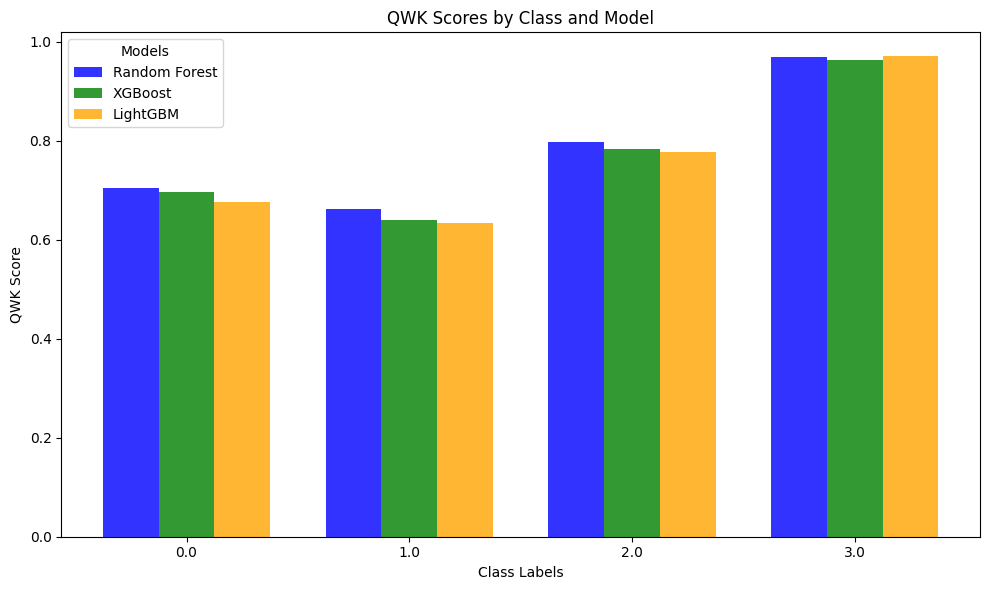

Best model for each class based on QWK:
Class 0.0: Random Forest
Class 1.0: Random Forest
Class 2.0: Random Forest
Class 3.0: LightGBM


In [13]:
# Split the training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Define the models
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'LightGBM': lgb
}

# Dictionary to store QWK scores for each class and model
performance_per_class_qwk = {model_name: {} for model_name in models.keys()}

# Evaluate each model on the validation set
for model_name, model in models.items():
    # Fit the model to the training data
    model.fit(X_train_final, y_train_final)
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate QWK for each class individually
    for class_label in np.unique(y_val):
        # Compare the true labels and predicted labels for this class
        qwk = cohen_kappa_score(
            (y_val == class_label).astype(int),
            (y_pred == class_label).astype(int),
            weights="quadratic"
        )
        performance_per_class_qwk[model_name][class_label] = qwk

# Convert performance results to a DataFrame
performance_df_qwk = pd.DataFrame(performance_per_class_qwk).T

# Transpose the DataFrame for grouped column chart
performance_df_qwk = performance_df_qwk.T

# Plot grouped column chart
fig, ax = plt.subplots(figsize=(10, 6))
class_labels = performance_df_qwk.index

# Bar width and positions
bar_width = 0.25
x = np.arange(len(class_labels))  # Group positions for the classes

# Define colors for the models
model_colors = {
    'Random Forest': 'blue',
    'XGBoost': 'green',
    'LightGBM': 'orange'
}

# Plot each model as a separate column within each group
for i, (model_name, color) in enumerate(model_colors.items()):
    ax.bar(
        x + i * bar_width,  # Offset for the model within the group
        performance_df_qwk[model_name],  # QWK scores
        bar_width,
        label=model_name,
        color=color,
        alpha=0.8
    )

# Customize the plot
ax.set_title("QWK Scores by Class and Model")
ax.set_xlabel("Class Labels")
ax.set_ylabel("QWK Score")
ax.set_xticks(x + bar_width)  # Set ticks in the middle of the group
ax.set_xticklabels(class_labels)  # Label the classes
ax.legend(title="Models", loc="upper left")
plt.tight_layout()

# Show the grouped column chart
plt.show()

# Determine the best model for each class
best_models_per_class_qwk = performance_df_qwk.idxmax(axis=1)

# Print the best model for each class
print("Best model for each class based on QWK:")
for class_label, model_name in best_models_per_class_qwk.items():
    print(f"Class {class_label}: {model_name}")
